In [1]:
import pandas as pd

# Read the raw data
# Note: Update the file path to where you downloaded and extracted the dataset
data = pd.read_csv('/content/SMSSpamCollection', sep='\t', names=['label', 'message'])

# Save as CSV
data.to_csv('spam.csv', index=False)


Model Performance Comparison:
--------------------------------------------------

Naive Bayes Classifier:
Accuracy: 0.965
Spam F1-Score: 0.849
Ham F1-Score: 0.980

SVM Classifier:
Accuracy: 0.992
Spam F1-Score: 0.969
Ham F1-Score: 0.995

Random Forest Classifier:
Accuracy: 0.978
Spam F1-Score: 0.912
Ham F1-Score: 0.988

Best performing model: SVM


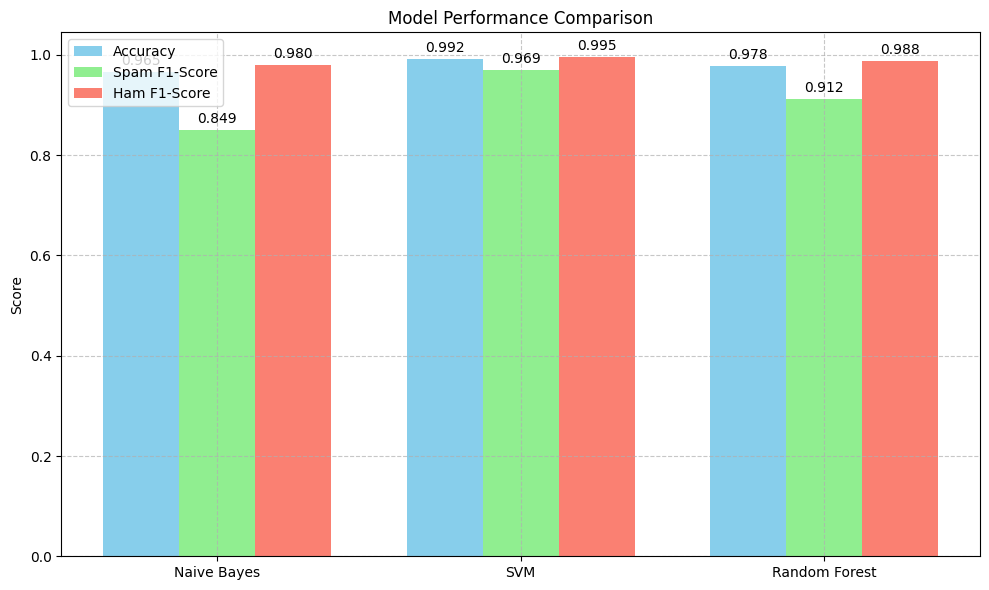


Best model prediction:
Message: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Model used: SVM
Is spam: False
Spam probability: 0.27

Spam probabilities from all models:
Naive Bayes: 0.012
SVM: 0.268
Random Forest: 0.000


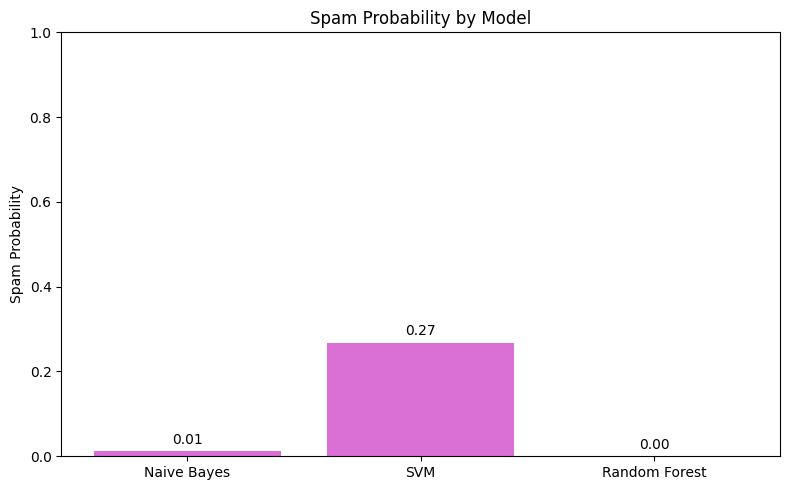

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pickle


class SMSSpamDetector:
    def __init__(self):
        self.vectorizer = TfidfVectorizer()
        self.models = {
            'Naive Bayes': MultinomialNB(),
            'SVM': LinearSVC(random_state=42),
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
        }
        self.best_model = None
        self.best_model_name = None
        self.model_metrics = {}

    def load_data(self, filepath):
        df = pd.read_csv(filepath, encoding='latin-1')
        return df

    def preprocess_data(self, df):
        df['label'] = df['label'].map({'spam': 1, 'ham': 0})
        return df

    def plot_model_comparison(self):
        model_names = list(self.model_metrics.keys())
        accuracy = [metrics['accuracy'] for metrics in self.model_metrics.values()]
        spam_f1 = [metrics['spam_f1'] for metrics in self.model_metrics.values()]
        ham_f1 = [metrics['ham_f1'] for metrics in self.model_metrics.values()]

        x = np.arange(len(model_names))
        width = 0.25

        fig, ax = plt.subplots(figsize=(10, 6))
        bars1 = ax.bar(x - width, accuracy, width, label='Accuracy', color='skyblue')
        bars2 = ax.bar(x, spam_f1, width, label='Spam F1-Score', color='lightgreen')
        bars3 = ax.bar(x + width, ham_f1, width, label='Ham F1-Score', color='salmon')

        ax.set_ylabel('Score')
        ax.set_title('Model Performance Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names)
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)

        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.3f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom', rotation=0)

        autolabel(bars1)
        autolabel(bars2)
        autolabel(bars3)

        plt.tight_layout()
        plt.savefig('model_comparison.png')
        plt.show()

    def train_and_evaluate(self, X_train, X_test, y_train, y_test):
        X_train_tfidf = self.vectorizer.fit_transform(X_train)
        X_test_tfidf = self.vectorizer.transform(X_test)

        best_f1 = 0

        print("\nModel Performance Comparison:")
        print("-" * 50)

        for name, model in self.models.items():
            model.fit(X_train_tfidf, y_train)
            predictions = model.predict(X_test_tfidf)
            report = classification_report(y_test, predictions, output_dict=True)

            self.model_metrics[name] = {
                'accuracy': report['accuracy'],
                'spam_f1': report['1']['f1-score'],
                'ham_f1': report['0']['f1-score']
            }

            print(f"\n{name} Classifier:")
            print(f"Accuracy: {report['accuracy']:.3f}")
            print(f"Spam F1-Score: {report['1']['f1-score']:.3f}")
            print(f"Ham F1-Score: {report['0']['f1-score']:.3f}")

            if report['weighted avg']['f1-score'] > best_f1:
                best_f1 = report['weighted avg']['f1-score']
                self.best_model = model
                self.best_model_name = name

        print(f"\nBest performing model: {self.best_model_name}")
        self.plot_model_comparison()

    def predict(self, message):
        message_tfidf = self.vectorizer.transform([message])
        prediction = self.best_model.predict(message_tfidf)

        if isinstance(self.best_model, LinearSVC):
            confidence = self.best_model.decision_function(message_tfidf)
            probability = 1 / (1 + np.exp(-confidence[0]))
        else:
            probability = self.best_model.predict_proba(message_tfidf)[0][1]

        return {
            'is_spam': bool(prediction[0]),
            'spam_probability': float(probability),
            'model_used': self.best_model_name
        }

    def predict_all_models(self, message):
        message_tfidf = self.vectorizer.transform([message])
        probabilities = {}

        for name, model in self.models.items():
            if isinstance(model, LinearSVC):
                confidence = model.decision_function(message_tfidf)
                probability = 1 / (1 + np.exp(-confidence[0]))
            else:
                probability = model.predict_proba(message_tfidf)[0][1]
            probabilities[name] = float(probability)

        return probabilities

    def plot_spam_probabilities(self, probabilities):
        model_names = list(probabilities.keys())
        probs = list(probabilities.values())

        plt.figure(figsize=(8, 5))
        bars = plt.bar(model_names, probs, color='orchid')
        plt.ylabel("Spam Probability")
        plt.title("Spam Probability by Model")
        plt.ylim(0, 1)

        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2.0, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.savefig("spam_probabilities.png")
        plt.show()

    def save_model(self, model_path, vectorizer_path):
        with open(model_path, 'wb') as f:
            pickle.dump(self.best_model, f)
        with open(vectorizer_path, 'wb') as f:
            pickle.dump(self.vectorizer, f)

    def load_model(self, model_path, vectorizer_path):
        with open(model_path, 'rb') as f:
            self.best_model = pickle.load(f)
        with open(vectorizer_path, 'rb') as f:
            self.vectorizer = pickle.load(f)


def main():
    detector = SMSSpamDetector()

    # Load and preprocess data
    df = detector.load_data('/content/spam.csv')  # Adjust path as needed
    df = detector.preprocess_data(df)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        df['message'], df['label'], test_size=0.2, random_state=42
    )

    # Train and evaluate models
    detector.train_and_evaluate(X_train, X_test, y_train, y_test)

    # Example prediction
    test_message = "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."

    # Best model prediction
    result = detector.predict(test_message)
    print("\nBest model prediction:")
    print(f"Message: {test_message}")
    print(f"Model used: {result['model_used']}")
    print(f"Is spam: {result['is_spam']}")
    print(f"Spam probability: {result['spam_probability']:.2f}")

    # All model predictions
    all_probs = detector.predict_all_models(test_message)
    print("\nSpam probabilities from all models:")
    for model, prob in all_probs.items():
        print(f"{model}: {prob:.3f}")

    # Plot the comparison
    detector.plot_spam_probabilities(all_probs)

    # Save best model
    detector.save_model('spam_model.pkl', 'vectorizer.pkl')


if __name__ == "__main__":
    main()
